# NN Heston Model - Model Training

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

## Data Preprocessing

**Initialization**

In [2]:
import re

verbose    = True
TAG        = '100000_MCA'

inFile     = "full_%s.csv" %(TAG)
scalerFile = "scaler_%s.pkl" %(TAG)
mdlDir     = "model_%s.krs" %(TAG)
    
resFile    = re.sub("\..*$","_trained.png", inFile)
print("%s -> %s" %(inFile, resFile))    

full_100000_MCA.csv -> full_100000_MCA_trained.png


**Read the training DB**

In [3]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()

Saving full_100000_MCA.csv to full_100000_MCA.csv


In [4]:
# Read in training data
print("@ %-24s: reading from '%s'" %("Info", inFile))
db = pd.read_csv(inFile, sep=',')

@ Info                    : reading from 'full_100000_MCA.csv'


check that it is is what we expect

In [5]:
print("*"*82+"\n"+"* X"); print(db.keys()); print("*"*82)
print(db.head(4))

**********************************************************************************
* X
Index(['k', 'theta', 'sigma', 'v0', 'rho', 'T', 'Strike', 'Price'], dtype='object')
**********************************************************************************
          k     theta     sigma        v0       rho         T    Strike  \
0  0.126389  0.636774  0.443031  0.792941 -0.107638  1.971662  1.217852   
1  0.130231  0.115161  0.380998  0.770774 -0.560622  1.546871  0.724220   
2  0.780878  0.558319  0.366306  0.035655 -0.597480  1.194933  1.051100   
3  0.733418  0.601390  0.183116  0.604345 -0.025319  1.091605  0.916156   

      Price  
0  0.612223  
1  0.213134  
2  0.225639  
3  0.261065  


In [6]:
from sklearn.preprocessing import StandardScaler

'''
    It is critical that any data preparation performed on a training dataset is also performed 
    on a new dataset in the future. This may include a test dataset when evaluating a model 
    or new data from the domain when using a model to make predictions. Typically, the model fit 
    on the training dataset is saved for later use. The correct solution to preparing new data 
    for the model in the future is to also save any data preparation objects, like data scaling methods, 
    to file along with the model.
'''

def preprocess(**keywrds):

    db = keywrds["db"]
    

    # Specify the target labels and flatten the array 
    #t=np.ravel(db["Price"])
    t=db["Price"]

    # Specify the data 
    X = db.drop(columns="Price")

    print("Info")
    print(X.info())

    print("Head")
    print(X.head(n=2))
    print("Tail")
    print(X.tail(n=2))

    print("Describe")
    print(X.describe())


    # Define the scaler 
    scaler = StandardScaler().fit(X)

    # Split the data up in train and test sets
    X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.33, random_state=42)

    # Scale the train set
    X_train = scaler.transform(X_train)

    # Scale the test set
    X_test = scaler.transform(X_test)

    return scaler, X_train, X_test, t_train, t_test

In [7]:
scaler, X_train, X_test, t_train, t_test = preprocess(db = db)

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66983 entries, 0 to 66982
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   k       66983 non-null  float64
 1   theta   66983 non-null  float64
 2   sigma   66983 non-null  float64
 3   v0      66983 non-null  float64
 4   rho     66983 non-null  float64
 5   T       66983 non-null  float64
 6   Strike  66983 non-null  float64
dtypes: float64(7)
memory usage: 3.6 MB
None
Head
          k     theta     sigma        v0       rho         T    Strike
0  0.126389  0.636774  0.443031  0.792941 -0.107638  1.971662  1.217852
1  0.130231  0.115161  0.380998  0.770774 -0.560622  1.546871  0.724220
Tail
              k     theta     sigma        v0       rho         T    Strike
66981  0.493719  0.773586  0.545387  0.663587 -0.760008  1.791994  0.870116
66982  0.961088  0.606730  0.509816  0.145584 -0.795391  1.988030  1.109212
Describe
                  k         theta         sigm

## Auxiliary Functions

In [8]:
def show_scattered( y, t, tag, ax = None):
    #x      = model.predict(X)
    #y      = np.ravel(x)
    xMin = min(t)
    xMax = max(t)
    v    = np.arange(xMin, xMax, (xMax-xMin)/100.)

    diff   = np.fabs(y - t)
    print("@ %-24s: E[y-t]: %.6f Std(y-t): %.6f" %( tag, np.mean(diff), np.std(diff)))
    if ax == None: return

    ax.plot( y, t, ".")
    ax.plot( v, v, color="red")
    ax.set_title("%s mae=%8.4f, std=%8.4f" %(tag, np.mean(diff), np.std(diff)))
    ax.set_xlabel("predicted")
    ax.set_ylabel("target")

In [9]:
def display_nn_results( model, X_train, X_test, t_train, t_test, resFile=None):

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    fig.suptitle("Scattered plots")

    y_train  = np.ravel(model.predict(X_train))
    show_scattered( y_train, t_train, "InSample", ax = ax[0])
    
    diff   = np.fabs(y_train - t_train)
    RES    = pd.DataFrame({"predicted": y_train, "target": t_train, "err:": diff})
    RES.to_csv("res_in__sample.csv", sep=',', float_format="%.6f", index=True)
    print("@")
    y_test  = np.ravel(model.predict(X_test))
    show_scattered( y_test , t_test, "OutOfSample", ax= ax[1])
    
    diff   = np.fabs(y_test-t_test)
    RES    = pd.DataFrame({"predicted": y_test, "target": t_test, "err:": diff})
    RES.to_csv("res_out_sample.csv", sep=',', float_format="%.6f", index=True)

    print("@")

    if resFile != None:
        plt.savefig(resFile, format="png")
        print("@ %-12s: results saved to '%s' "%("Info", resFile))
    plt.show()


    score = model.evaluate(X_test, t_test, verbose=1)
    print('Score:'); print(score)

## Build the model

In [10]:
from keras.models import Sequential
from keras.layers import Dense

def model_builder( inputShape = (1,)):
    
    # Initialize the constructor
    model = Sequential()

    # Add an input layer 
    model.add(Dense(128, activation='relu', input_shape=inputShape))

    # Add one more hidden layer 
    model.add(Dense(64, activation='relu'))

    # Add one more hidden layer 
    model.add(Dense(32, activation='relu'))

    # Add one more hidden layer 
    model.add(Dense(16, activation='relu'))

    # Add an output layer 
    model.add(Dense(1))
    # End model construction

    # Model output shape
    print("model.output_shape: %s" %(str(model.output_shape)))

    # Model summary
    print("Model.summary"); model.summary()

    # Model config
    print("Model.config"); model.get_config()

    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model


Let’s go through this code line by line:

- The first line creates a **Sequential** model. This is the simplest kind of Keras model, for neural networks that are just composed of a single stack of layers, connected sequentially. This is called the sequential API.

- Next, we build the first layer and add it to the model. It is a **Dense** hidden layer with XXX neurons. It will use the **ReLu** activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron).

- Next we add a second Dense hidden layer with XXX neurons, also using the ReLu activation function and a third one ...

- Finally, we add a Dense output layer with only 1 neurons, using the ReLu activation function (because...).


In [11]:
model = model_builder( inputShape = (X_train.shape[1],))

model.output_shape: (None, 1)
Model.summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
_________________________________________________________________
Model.co

Note that Dense layers often have a lot of parameters. For example, the first hidden
layer has n × n connection weights, plus 300 bias terms, which adds up to
XXX parameters! This gives the model quite a lot of flexibility to fit the training
data, but it also means that the model runs the risk of overfitting, especially when you
do not have a lot of training data.

You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch
it by name:

In [12]:
model.layers

In [13]:
model.layers[1].name

'dense_1'

After a model is created, you must call its ***compile()*** method to specify the loss function
and the optimizer to use. Optionally, you can also specify a list of extra metrics to
compute during training and evaluation. In this case we have chosen

`model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])`



## Train the model

Now the model is ready to be trained. For this we simply need to call its ***fit()***
method. We pass it the input features (***X_train***) and the target classes (***y_train***), as
well as the number of epochs to train (or else it would default to just 1, which would
definitely not be enough to converge to a good solution). We could also pass a validation set
(this is optional): Keras will measure the loss and the extra metrics on this set at the
end of each epoch, which is very useful to see how well the model really performs: if
the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a data mismatch
between the training set and the validation set).

In [14]:
history = model.fit(X_train, t_train, epochs=50, verbose=verbose)

Epoch 1/50
1403/1403 [==============================] - 3s 2ms/step - loss: 7.2913e-04 - mae: 0.0164
Epoch 2/50
1403/1403 [==============================] - 2s 2ms/step - loss: 1.1645e-04 - mae: 0.0082
Epoch 3/50
1403/1403 [==============================] - 2s 2ms/step - loss: 7.4291e-05 - mae: 0.0065
Epoch 4/50
1403/1403 [==============================] - 2s 2ms/step - loss: 5.7481e-05 - mae: 0.0057
Epoch 5/50
1403/1403 [==============================] - 2s 2ms/step - loss: 4.8465e-05 - mae: 0.0052
Epoch 6/50
1403/1403 [==============================] - 2s 2ms/step - loss: 4.2760e-05 - mae: 0.0049
Epoch 7/50
1403/1403 [==============================] - 2s 2ms/step - loss: 3.8206e-05 - mae: 0.0047
Epoch 8/50
1403/1403 [==============================] - 2s 2ms/step - loss: 3.5271e-05 - mae: 0.0045
Epoch 9/50
1403/1403 [==============================] - 2s 2ms/step - loss: 3.2683e-05 - mae: 0.0043
Epoch 10/50
1403/1403 [==============================] - 2s 2ms/step - loss: 3.0516e-05 - m

And that’s it! The neural network is trained. At each epoch during training, Keras displays
the number of instances processed so far (along with a progress bar), the mean
training time per sample, the loss and accuracy (or any other extra metrics you asked
for), both on the training set and the validation set. You can see that the training loss
went down, which is a good sign, and the validation accuracy reached XXX% after 50
epochs, not too far from the training accuracy, so there does not seem to be much
overfitting going on.

All the parameters of a layer can be accessed using its ***get_weights()*** and
***set_weights()*** method. For a Dense layer, this includes both the connection weights
and the bias terms:

In [15]:
weights, biases = model.layers[1].get_weights()
weights

array([[-0.11607509,  0.19852339, -0.00103556, ...,  0.35739708,
         0.0084412 , -0.23186955],
       [ 0.16863641, -0.00900264, -0.17846903, ...,  0.27516392,
        -0.20104608,  0.07653546],
       [-0.02975945, -0.21526006,  0.0473051 , ..., -0.5145115 ,
         0.08695859, -0.27977517],
       ...,
       [ 0.12554696, -0.02724885, -0.09989464, ...,  0.16117111,
         0.02140428,  0.08092505],
       [-0.2977736 ,  0.23091325, -0.17245093, ...,  0.29316285,
        -0.18662715,  0.0749253 ],
       [ 0.00937123, -0.08167892, -0.0564459 , ..., -0.27299428,
        -0.10587758, -0.07459451]], dtype=float32)

@ InSample                : E[y-t]: 0.001640 Std(y-t): 0.001462
@
@ OutOfSample             : E[y-t]: 0.001667 Std(y-t): 0.001470
@
@ Info        : results saved to 'full_100000_MCA_trained.png' 


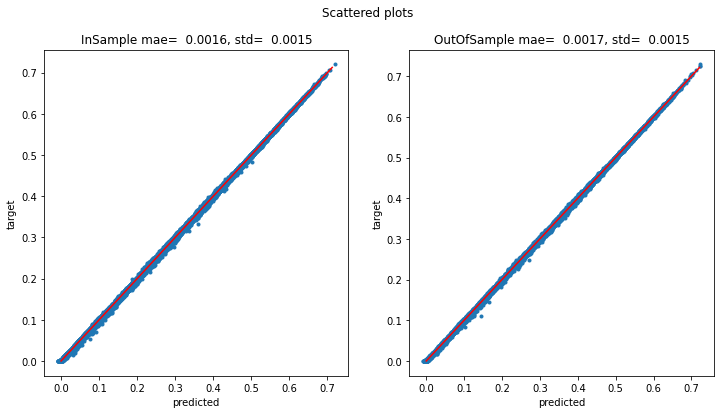

691/691 [==============================] - 1s 1ms/step - loss: 4.9395e-06 - mae: 0.0017
Score:
[4.9394725465390366e-06, 0.0016671218909323215]


In [16]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy             as np

display_nn_results(model, X_train, X_test, t_train, t_test, resFile = resFile)

The ***fit()*** method returns a History object containing the training parameters (his
tory.params), the list of epochs it went through (history.epoch), and most importantly
a dictionary (history.history) containing the loss and extra metrics it
measured at the end of each epoch on the training set and on the validation set (if any). If you create a Pandas DataFrame using this dictionary and call its plot()
method, you get the learning curves shown in ...

In [17]:
X = db.drop(columns="Price")
Y = db["Price"]

In [18]:
# Fit the model
history = model.fit(X, Y, validation_split=0.33, epochs=50, verbose=1)

Epoch 1/50
1403/1403 [==============================] - 4s 3ms/step - loss: 0.0017 - mae: 0.0227 - val_loss: 1.0783e-04 - val_mae: 0.0078
Epoch 2/50
1403/1403 [==============================] - 4s 3ms/step - loss: 1.9775e-04 - mae: 0.0109 - val_loss: 4.6545e-05 - val_mae: 0.0048
Epoch 3/50
1403/1403 [==============================] - 4s 3ms/step - loss: 1.5779e-04 - mae: 0.0098 - val_loss: 1.4953e-04 - val_mae: 0.0105
Epoch 4/50
1403/1403 [==============================] - 4s 3ms/step - loss: 1.3331e-04 - mae: 0.0090 - val_loss: 1.0239e-04 - val_mae: 0.0084
Epoch 5/50
1403/1403 [==============================] - 4s 3ms/step - loss: 1.1684e-04 - mae: 0.0084 - val_loss: 1.8944e-04 - val_mae: 0.0123
Epoch 6/50
1403/1403 [==============================] - 4s 3ms/step - loss: 1.0840e-04 - mae: 0.0082 - val_loss: 4.6555e-05 - val_mae: 0.0055
Epoch 7/50
1403/1403 [==============================] - 4s 3ms/step - loss: 1.0183e-04 - mae: 0.0080 - val_loss: 1.7868e-04 - val_mae: 0.0121
Epoch 8/50

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


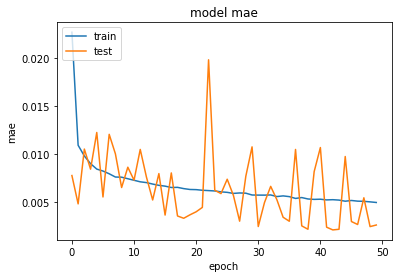

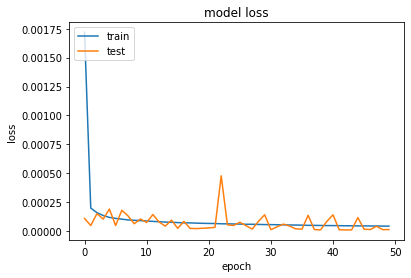

In [19]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save Scaler and Model on Disk

In [ ]:
from pickle import dump, load

dump(scaler, open(scalerFile, 'wb'))
print("@ %-24s: scaler saved to '%s'" %("Info", scalerFile))

model.save(mdlDir)
print("@ %-24s: model saved to '%s'" %("Info", mdlDir))    

@ Info                    : scaler saved to 'scaler_001024_MCA.pkl'
INFO:tensorflow:Assets written to: model_001024_MCA.krs/assets
@ Info                    : model saved to 'model_001024_MCA.krs'


In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.download(scalerFile)
    #files.download(mdlDir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>